In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Step 1: Configuration
original_dir = "./rice_leaf_dataset"  # Path to your dataset
output_dir = "./dataset"             # Where train_val and test are located
test_split = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2
random.seed(42)

In [3]:
# Step 3: Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input  # ResNet-specific preprocessing
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train_val'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train_val'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())
print(f"Classes: {NUM_CLASSES}, Labels: {class_labels}")
print(f"Train images: {train_generator.samples}, Validation images: {val_generator.samples}, Test images: {test_generator.samples}")

Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Classes: 4, Labels: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']
Train images: 3799, Validation images: 948, Test images: 1185


In [4]:
# Step 4: Build ResNet50 model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=x)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
resnet_base.trainable = False  # Freeze base model
resnet_model = build_model(resnet_base)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [5]:
# Step 5: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("./resnet50_rice_leaf_best.h5", monitor='val_loss', save_best_only=True)

In [6]:
# Step 6: Train model
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

c:\Users\longp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3232 - loss: 1.4041

76/76 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.3240 - loss: 1.4034 - val_accuracy: 0.4451 - val_loss: 1.3101 - learning_rate: 1.0000e-04
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4345 - loss: 1.2932

76/76 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.4345 - loss: 1.2930 - val_accuracy: 0.4283 - val_loss: 1.2625 - learning_rate: 1.0000e-04
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4748 - loss: 1.2404

76/76 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.4749 - loss: 1.2404 - val_accuracy: 0.4916 - val_loss: 1.2373 - learning_rate: 1.0000e-04
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4362 - loss: 1.2221

76/76 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.4364 - loss: 1.2220 - val_accuracy: 0.5074 - val_loss: 1.2151 - learning_rate: 1.0000e-04
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4676 - loss: 1.1982

76/76 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.4676 - loss: 1.1981 - val_accuracy: 0.4895 - val_loss: 1.2079 - learning_rate: 1.0000e-04
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5097 - loss: 1.1731

76/76 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.5095 - loss: 1.1731 - val_accuracy: 0.4736 - val_loss: 1.1855 - learning_rate: 1.0000e-04
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5025 - loss: 1.1758

76/76 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.5025 - loss: 1.1756 - val_accuracy: 0.4631 - val_loss: 1.1765 - learning_rate: 1.0000e-04
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5169 - loss: 1.1457

76/76 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5169 - loss: 1.1458 - val_accuracy: 0.5042 - val_loss: 1.1716 - learning_rate: 1.0000e-04
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5294 - loss: 1.1416

76/76 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5294 - loss: 1.1416 - val_accuracy: 0.4715 - val_loss: 1.1569 - learning_rate: 1.0000e-04
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.5402 - loss: 1.1358 - val_accuracy: 0.4757 - val_loss: 1.1595 - learning_rate: 1.0000e-04
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5169 - loss: 1.1208

76/76 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5171 - loss: 1.1208 - val_accuracy: 0.5295 - val_loss: 1.1453 - learning_rate: 1.0000e-04
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5508 - loss: 1.1090

76/76 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5507 - loss: 1.1091 - val_accuracy: 0.5485 - val_loss: 1.1413 - learning_rate: 1.0000e-04
Epoch 13/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5553 - loss: 1.0957

76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5552 - loss: 1.0959 - val_accuracy: 0.5538 - val_loss: 1.1399 - learning_rate: 1.0000e-04
Epoch 14/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5498 - loss: 1.1005

76/76 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.5498 - loss: 1.1005 - val_accuracy: 0.5401 - val_loss: 1.1355 - learning_rate: 1.0000e-04
Epoch 15/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.5786 - loss: 1.0802 - val_accuracy: 0.5612 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 16/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5562 - loss: 1.1061

76/76 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.5563 - loss: 1.1059 - val_accuracy: 0.5432 - val_loss: 1.1206 - learning_rate: 1.0000e-04
Epoch 17/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5806 - loss: 1.0912

76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5807 - loss: 1.0910 - val_accuracy: 0.5717 - val_loss: 1.1206 - learning_rate: 1.0000e-04
Epoch 18/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5948 - loss: 1.0802 - val_accuracy: 0.5549 - val_loss: 1.1248 - learning_rate: 1.0000e-04
Epoch 19/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5768 - loss: 1.0718 - val_accuracy: 0.4968 - val_loss: 1.1242 - learning_rate: 1.0000e-04
Epoch 20/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5728 - loss: 1.0611

76/76 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5730 - loss: 1.0612 - val_accuracy: 0.5137 - val_loss: 1.1031 - learning_rate: 1.0000e-04


In [9]:
# Step 7: Evaluate model
val_loss, val_acc = resnet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6215 - loss: 0.9815
Validation Loss: 1.1099, Accuracy: 0.5127
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6228 - loss: 0.9885
Test Loss: 1.0873, Accuracy: 0.5409


24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.56      0.72      0.63       316
          Blast       0.36      0.36      0.36       288
      Brownspot       0.61      0.84      0.71       320
         Tungro       0.98      0.16      0.27       261

       accuracy                           0.54      1185
      macro avg       0.62      0.52      0.49      1185
   weighted avg       0.61      0.54      0.50      1185



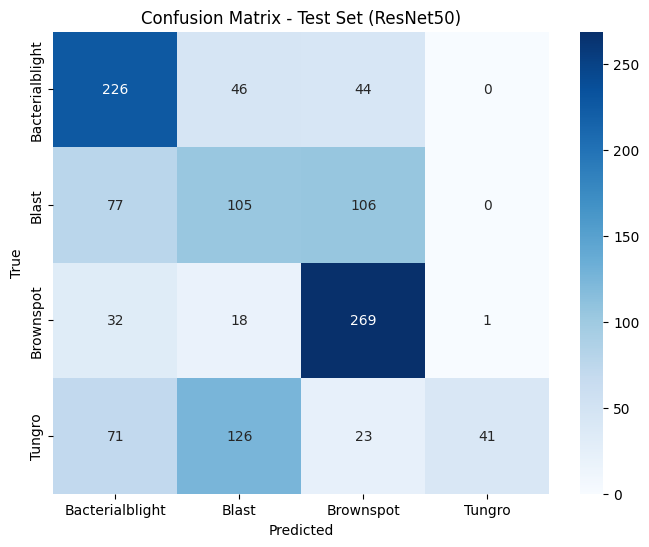

In [10]:
# Step 8: Classification report and confusion matrix
test_generator.reset()
test_preds = resnet_model.predict(test_generator)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y_true, test_y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Test Set (ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('./confusion_matrix_test_resnet.png')
plt.show()

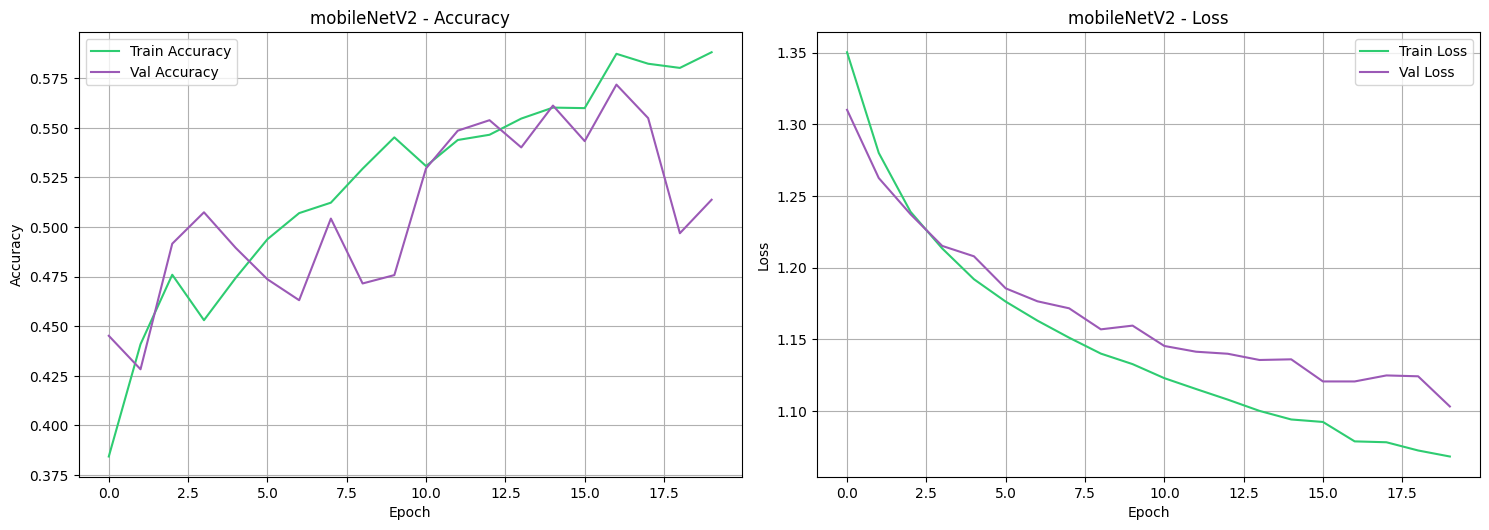

In [13]:
# Step 9: Plot training history 
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history.get('precision', [])
    val_precision = history.history.get('val_precision', [])
    recall = history.history.get('recall', [])
    val_recall = history.history.get('val_recall', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 10))
    
    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='#2ecc71')  # Green
    plt.plot(epochs_range, val_acc, label='Val Accuracy', color='#9b59b6')  # Purple
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='#2ecc71')
    plt.plot(epochs_range, val_loss, label='Val Loss', color='#9b59b6')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Precision plot
    if precision and val_precision:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, precision, label='Train Precision', color='#2ecc71')
        plt.plot(epochs_range, val_precision, label='Val Precision', color='#9b59b6')
        plt.title(f'{title} - Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)
    
    # Recall plot
    if recall and val_recall:
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, recall, label='Train Recall', color='#2ecc71')
        plt.plot(epochs_range, val_recall, label='Val Recall', color='#9b59b6')
        plt.title(f'{title} - Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('./training_history_resnet.png', dpi=300)
    plt.show()

plot_history(resnet_history, "mobileNetV2")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test image: ./dataset\test\Blast\BLAST5_075.jpg
True class: Blast
Predicted class: Blast
Confidence: 0.9917


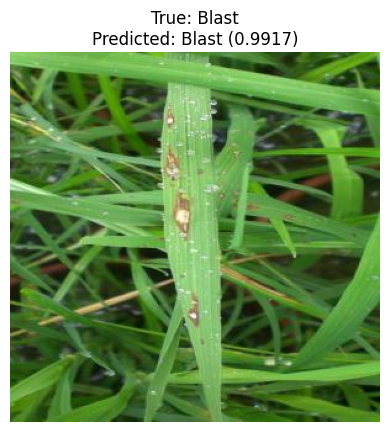

In [12]:
# Step 10: Test on a random image
model = tf.keras.models.load_model('./resnet50_rice_leaf_best.h5')
image_paths = []
for class_name in os.listdir(os.path.join(output_dir, 'test')):
    class_path = os.path.join(os.path.join(output_dir, 'test'), class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

test_img_path = random.choice(image_paths)
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # ResNet-specific preprocessing
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]
true_class = os.path.basename(os.path.dirname(test_img_path))

print(f"Test image: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

plt.figure()
plt.imshow(load_img(test_img_path))  # Display original image
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('./test_result_resnet.png')
plt.show()

# Step 11: Save final model
resnet_model.save("./resnet50_rice_final.h5")